In [4]:
import os
import sys
sys.path.append(os.path.abspath('..'))
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from pyspark.sql.functions import sum,col,desc,count,round
from utils.read import read_csv_files
from utils.visualization import bar_plot, bar_graph
import logging 


In [6]:
# Define the path variable
CLEANED_DATA_PATH = "/spark-data/capstone_crm/data/cleaned/"
logging.info("Customer Purchase Analysis................................. ")

In [7]:
try:
    logging.info("loading customer.csv and transaction.csv")
    # read customers data
    customers_df = read_csv_files(f"{CLEANED_DATA_PATH}customers.csv")
    # read transactions data
    transactions_df = read_csv_files(f"{CLEANED_DATA_PATH}transactions.csv")
except FileNotFoundError as e:
        logging.error(f"Error reading CSV files : {e}", exc_info=True)
        raise  

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/09 09:44:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Analyze customer purchase behavior 

In [8]:
try:    
    # get the total spending of the customer
    total_spending_df = transactions_df.groupBy("customer_id").agg(sum("Amount").alias("Total_Spending"),count("*").alias("Purchase_Frequency"))
    total_spending_df = total_spending_df.withColumn("Avg_spending", round(col("Total_Spending") / col("Purchase_Frequency"), 2))
    joined_df = total_spending_df.join(customers_df,'customer_id','inner')
    joined_df = joined_df.select(col("customer_id"),col("Name"),col("total_Spending"),col("Purchase_Frequency"),col("Avg_spending"),col("Country"))
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True)    

### Top Customers on total spending

+----------------+-----------------+--------------------+
|            Name|   total_Spending|             Country|
+----------------+-----------------+--------------------+
|   Tracy Carroll|2510.780163599182|United States Vir...|
|Alexandra Medina|           2123.0|            Bulgaria|
|    Glenn Fisher|2029.780163599182|           Indonesia|
|     Daniel Cruz|1997.780163599182|           Argentina|
| Juan Washington|           1992.0|               Nepal|
|    Donna Graham|1968.780163599182|        Saint Helena|
|  Sandra Griffin|           1871.0|        Saudi Arabia|
|    Monica Patel|1868.780163599182|              Panama|
|    Bernard Mack|           1842.0|           Sri Lanka|
|    Raymond Beck|           1825.0|            Malaysia|
+----------------+-----------------+--------------------+



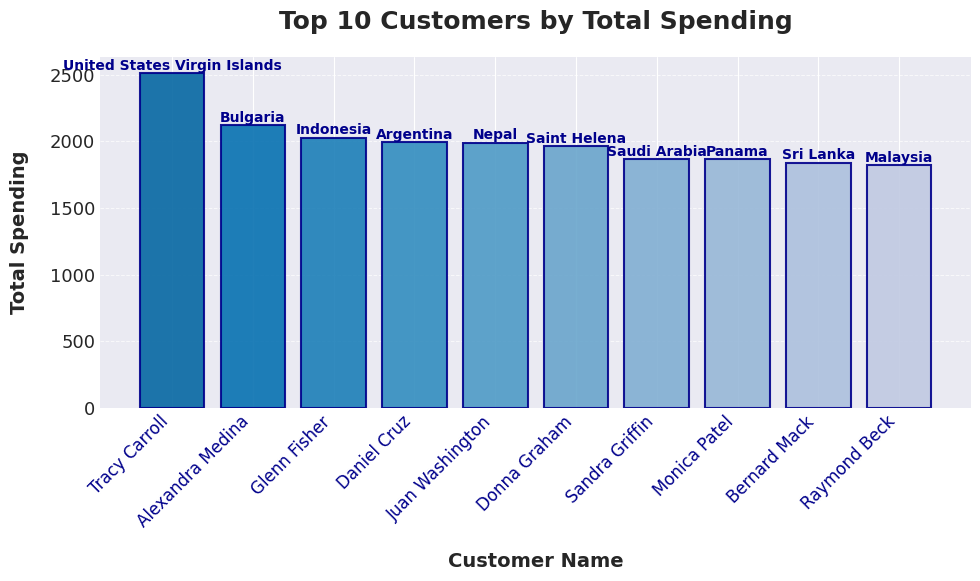

In [15]:
try:
    logging.info("top 10 customers on total spending")    
    #Get the top 10 customers based on total spending.
    top_ten_customers_df = joined_df.select("Name","total_Spending","Country").orderBy(desc("total_Spending")).limit(10)
    top_ten_customers_df.show() 
    
    #Convert to pandas dataFrame
    top_10_customers_pd = top_ten_customers_df.limit(10).toPandas()
    logging.info("plotting top 10 customer on total spending")  
     
    # Plotting the results using Matplotlib - Vertical Bar Char
    # Setting the style
    plt.style.use('seaborn-v0_8-darkgrid')

    # Create a larger figure
    plt.figure(figsize=(10, 6))

    # Create the bar chart with a gradient color for better aesthetics
    bars = plt.bar(
        top_10_customers_pd['Name'], 
        top_10_customers_pd['total_Spending'], 
        color=plt.cm.PuBu(np.linspace(0.8, 0.3, len(top_10_customers_pd))),
        edgecolor='darkblue', 
        linewidth=1.5,
        alpha=0.9
    )

    # Adding Country Names on Top of Each Bar
    for bar, country in zip(bars, top_10_customers_pd['Country']):
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2, yval + 0.5,  # Adjust position
            country, ha='center', va='bottom',
            fontsize=10, fontweight='bold', color='darkblue'
        )

    # Labels and Title with custom font and padding
    plt.xlabel('Customer Name', fontsize=14, fontweight='bold', labelpad=15)
    plt.ylabel('Total Spending', fontsize=14, fontweight='bold', labelpad=15)
    plt.title('Top 10 Customers by Total Spending', fontsize=18, fontweight='bold', pad=20)

    # Rotate the x-axis labels for readability
    plt.xticks(rotation=45, ha='right', fontsize=12, color='darkblue')

    # Adding grid lines to enhance readability
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

    # Adding a subtle shadow to bars for a 3D effect

    # Customize the spines (axis lines)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_color('darkblue')
    plt.gca().spines['bottom'].set_color('darkblue')

    # Show the plot
    plt.tight_layout()  # Adjusts plot to ensure everything fits nicely
    plt.show()
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True)    


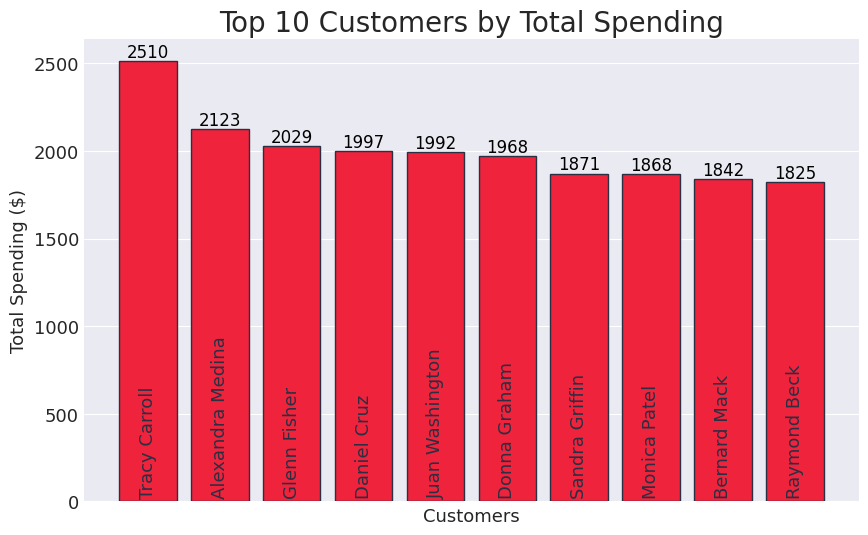

In [14]:
# Convert the columns from Spark DataFrame to Python lists
categories = [row['Name'] for row in top_ten_customers_df.collect()]  # Customer names
values = [row['total_Spending'] for row in top_ten_customers_df.collect()]  # Corresponding total spending

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(10, 6))

# Call the bar_graph function
bar_graph(
    ax=ax, 
    categories=categories, 
    values=values, 
    title="Top 10 Customers by Total Spending", 
    xlabel="Customers", 
    ylabel="Total Spending ($)", 
    # color='#3498db', 
    # edgecolor='#2B2F42'
)

# Display the plot
plt.show()

### Top customers who purchase most items 

+-----------------+------------------+--------------------+
|             Name|Purchase_Frequency|             Country|
+-----------------+------------------+--------------------+
|    Tracy Carroll|                 8|United States Vir...|
| Alexandra Medina|                 7|            Bulgaria|
|     Donna Graham|                 7|        Saint Helena|
|     Glenn Fisher|                 7|           Indonesia|
|     Monica Patel|                 7|              Panama|
|    Taylor Morgan|                 6|               Macao|
|      Taylor Buck|                 6|               India|
|  Juan Washington|                 6|               Nepal|
|     Bernard Mack|                 6|           Sri Lanka|
|Catherine Johnson|                 6|             Reunion|
+-----------------+------------------+--------------------+



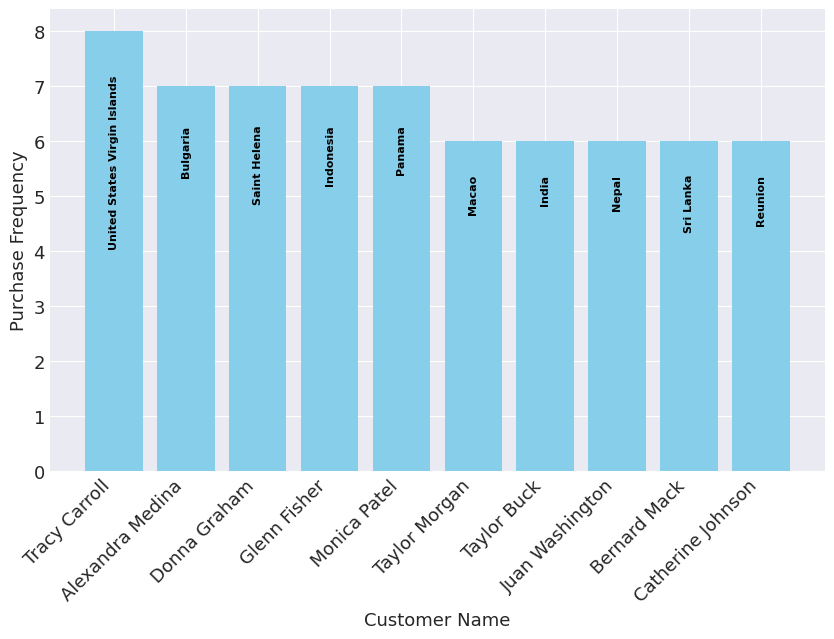

In [11]:
try:
    logging.info("Top 10 customers on purchase volume")
    #calculate purchase frequency per customer
    # Order by Purchase Frequency and Limit to Top 10
    top_10_frequency_df = joined_df.select("Name","Purchase_Frequency","Country").orderBy(desc("Purchase_Frequency")).limit(10)
    top_10_frequency_df.show()

    # Convert to Pandas DataFrame for Visualization
    top_10_frequency_pd = top_10_frequency_df.toPandas()

    # plotting bar graph
    bar_plot(dataframe=top_10_frequency_pd,x_col="Name",y_col="Purchase_Frequency",values_col="Country",x_label='Customer Name',y_label='Purchase Frequency',title='Top 10 Customers by Purchase Frequency')
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True) 


### Top customer on average purchase

In [12]:
try:
    logging.info("Top customers on average purchase")
    #calculate average purchase per customer
    # Order by Purchase Frequency and Limit to Top 10
    top_10_avg_spending = joined_df.select("Name","Avg_spending","Country").orderBy(desc("Avg_spending")).limit(10)
    top_10_avg_spending.show()
    
    # plotting bar graph
    bar_plot(dataframe=top_10_avg_spending_pd,x_col="Name",y_col="Avg_spending",values_col="Country",x_label='Customer Name',y_label='Average Spending',title='Top 10 Customers by Average Purchase')
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True)     


ERROR:root:invalid operation performed :{e}
Traceback (most recent call last):
  File "/tmp/ipykernel_43621/211385634.py", line 9, in <module>
    bar_plot(dataframe=top_10_avg_spending_pd,x_col="Name",y_col="Avg_spending",values_col="Country",x_label='Customer Name',y_label='Average Spending',title='Top 10 Customers by Average Purchase')
                       ^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'top_10_avg_spending_pd' is not defined


+-----------------+------------+--------------------+
|             Name|Avg_spending|             Country|
+-----------------+------------+--------------------+
|Andrea Richardson|       496.0|           Australia|
|    Brent Benitez|       490.0|     North Macedonia|
| Lindsey Bradford|       487.0|    Marshall Islands|
|  Paula Donaldson|       486.0|               Congo|
|     Mary Pacheco|       483.0|             Liberia|
|      James Gross|       482.5|United Arab Emirates|
|Michael Rasmussen|       477.0|               Kenya|
| Kimberly Sanchez|       474.0|        Sierra Leone|
|    Jordan Dawson|       466.0|                Chad|
|Timothy Cervantes|       464.0|             Belgium|
+-----------------+------------+--------------------+



### Top Countries with maximum customers

+--------------------+----------------------------+
|             Country|Customer_volume_Country_wise|
+--------------------+----------------------------+
|               Congo|                           6|
| Trinidad and Tobago|                           6|
|               Macao|                           5|
|   Equatorial Guinea|                           5|
|Sao Tome and Prin...|                           5|
|               Spain|                           5|
|            Barbados|                           5|
|                Iran|                           5|
|           Australia|                           5|
|               Nepal|                           5|
+--------------------+----------------------------+



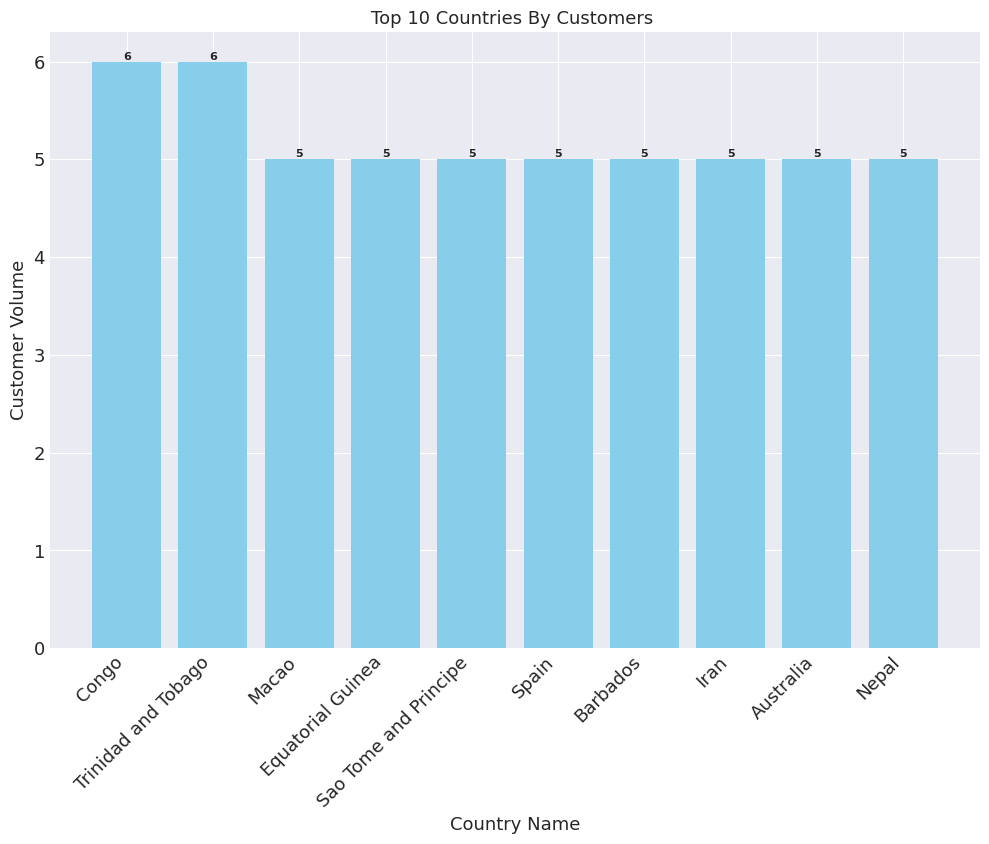

In [13]:
try:
    logging.info("Top 10 countries with maximum customer")
    #customer frequency according to country
    # Order by Purchase Frequency and Limit to Top 10
    customer_volume_country_wise_df = joined_df.groupBy("Country").agg(count("customer_id").alias("Customer_volume_Country_wise"))
    top_10_countries_with_maximum_customer_df = customer_volume_country_wise_df.select("Country","Customer_volume_Country_wise").orderBy(desc("Customer_volume_Country_wise")).limit(10)
    top_10_countries_with_maximum_customer_df.show()

    # Convert to Pandas DataFrame for Visualization
    top_10_countries_with_maximum_customer_pd = top_10_countries_with_maximum_customer_df.toPandas()

    # Plotting the results
    plt.figure(figsize=(12, 8))
    bars = plt.bar(top_10_countries_with_maximum_customer_pd['Country'], top_10_countries_with_maximum_customer_pd['Customer_volume_Country_wise'], color='skyblue')
    
    # Adding Country Names on Top of Each Bar
    for bar, customer_count in zip(bars, top_10_countries_with_maximum_customer_pd['Customer_volume_Country_wise']):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, customer_count, ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    plt.xlabel('Country Name')
    plt.ylabel('Customer Volume')
    plt.title('Top 10 Countries By Customers ')
    plt.xticks(rotation=45, ha='right') 
    plt.show()

except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True)     
